<a href="https://colab.research.google.com/github/Helena26-ai/Rainforcement_project/blob/Helena/Noisy_DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Zainstaluj PyTorch z obsługą CUDA 12.4
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124

Looking in indexes: https://download.pytorch.org/whl/cu124
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 50.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 86.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 45.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 110.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidi

In [2]:
!pip install gymnasium[atari,accept-rom-license]==0.29.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 31.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 68.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 88.9 MB/s eta 0:00:00
  Created wheel for AutoROM.accept-rom-license: filename=autorom_accept_rom_license-0.6.1-py3-none-any.whl size=446710 sha256=12f9fbc3ad9e5a58686594a6d8e27516c8f00175e2521b5206f8e448454542f2
  Stored in directory: /root/.cache/pip/wheels/bc/fc/c6/8aa657c0d2089982f2dabd110efc68c61eb49831fdb7397351
Successfully built AutoROM.accept-rom-license
  Attempting uninstall: gymnasium
    Found existing installation: gymnasium 1.1.1
    Uninstalling gymnasium-1.1.1:
      Successfully uninstalled gymnasium-1.1.1
  Attempting uninstall: ale-py
    Found existing installation: ale-py 0.11.0
    Uninstalling ale-py-0.11.0:
      Su

In [3]:
# Zainstaluj biblioteki RL i narzędzia
!pip install torchrl
!pip install stable-baselines3 tensorboard matplotlib -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 60.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 414.3/414.3 kB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.5/184.5 kB 15.9 MB/s eta 0:00:00


In [4]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import collections
import gymnasium as gym
from gymnasium import spaces
from torchrl.modules import NoisyLinear
from dataclasses import dataclass
import imageio.v2 as imageio
from stable_baselines3.common.atari_wrappers import AtariWrapper

/usr/local/lib/python3.11/dist-packages/torchrl/data/replay_buffers/samplers.py:34: UserWarning: Failed to import torchrl C++ binaries. Some modules (eg, prioritized replay buffers) may not work with your installation. This is likely due to a discrepancy between your package version and the PyTorch version. Make sure both are compatible. Usually, torchrl majors follow the pytorch majors within a few days around the release. For instance, TorchRL 0.5 requires PyTorch 2.4.0, and TorchRL 0.6 requires PyTorch 2.5.0.
  warnings.warn(EXTENSION_WARNING)


In [5]:
# === Wrappery ===
class ImageToPyTorch(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        obs = self.observation_space
        self.observation_space = spaces.Box(
            low=obs.low.min(), high=obs.high.max(),
            shape=(obs.shape[2], obs.shape[0], obs.shape[1]), dtype=obs.dtype)

    def observation(self, observation):
        return np.moveaxis(observation, 2, 0)

class BufferWrapper(gym.ObservationWrapper):
    def __init__(self, env, n_steps):
        super().__init__(env)
        self.buffer = collections.deque(maxlen=n_steps)
        obs = env.observation_space
        self.observation_space = spaces.Box(
            low=np.repeat(obs.low, n_steps, axis=0),
            high=np.repeat(obs.high, n_steps, axis=0),
            dtype=obs.dtype)

    def reset(self, **kwargs):
        for _ in range(self.buffer.maxlen - 1):
            self.buffer.append(self.env.observation_space.low)
        obs, info = self.env.reset(**kwargs)
        return self.observation(obs), info

    def observation(self, observation):
        self.buffer.append(observation)
        return np.concatenate(self.buffer)

def make_env(env_name: str, **kwargs):
    env = gym.make(env_name, **kwargs)
    env = AtariWrapper(env, clip_reward=False, noop_max=0)
    env = ImageToPyTorch(env)
    env = BufferWrapper(env, n_steps=4)
    return env

In [6]:
# === Parametry ===
ENV_NAME = "PongNoFrameskip-v4"
MEAN_REWARD_BOUND = 19
GAMMA = 0.99
BATCH_SIZE = 32
REPLAY_SIZE = 100000
LEARNING_RATE = 7.14e-5
SYNC_TARGET_FRAMES = 1000
REPLAY_START_SIZE = 10000
TEST_VIDEO_PATH = "noisy_dqn_test_run.mp4"
MODEL_SAVE_PATH = "noisy_dqn_best_model.dat"

In [7]:
# === Sieć Noisy DQN ===
class NoisyDQN(nn.Module):
    def __init__(self, input_shape, n_actions):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten()
        )
        conv_out_size = self.conv(torch.zeros(1, *input_shape)).shape[1]
        self.fc1 = NoisyLinear(conv_out_size, 512)
        self.fc2 = NoisyLinear(512, n_actions)

    def forward(self, x):
        x = x.float() / 255.0
        x = self.conv(x)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

    def reset_noise(self):
        self.fc1.reset_noise()
        self.fc2.reset_noise()

In [8]:
# === Bufor doświadczeń ===
@dataclass
class Experience:
    state: np.ndarray
    action: int
    reward: float
    done: bool
    new_state: np.ndarray

class ExperienceBuffer:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)

    def __len__(self):
        return len(self.buffer)

    def append(self, exp):
        self.buffer.append(exp)

    def sample(self, batch_size):
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        batch = [self.buffer[idx] for idx in indices]
        return batch

# === Agent ===
class Agent:
    def __init__(self, env, buffer):
        self.env = env
        self.buffer = buffer
        self.state, _ = env.reset()
        self.total_reward = 0.0

    def play_step(self, net, device):
        state_v = torch.tensor(np.array([self.state]), device=device)
        q_vals = net(state_v)
        action = torch.argmax(q_vals).item()

        new_state, reward, terminated, truncated, _ = self.env.step(action)
        done = terminated or truncated
        exp = Experience(self.state, action, reward, done, new_state)
        self.buffer.append(exp)
        self.total_reward += reward
        self.state = new_state

        if done:
            r = self.total_reward
            self.state, _ = self.env.reset()
            self.total_reward = 0.0
            return r
        return None

# === Przetwarzanie batcha ===
def batch_to_tensors(batch, device):
    states = torch.tensor(np.array([e.state for e in batch]), device=device)
    actions = torch.tensor([e.action for e in batch], dtype=torch.long, device=device)
    rewards = torch.tensor([e.reward for e in batch], dtype=torch.float32, device=device)
    dones = torch.tensor([e.done for e in batch], dtype=torch.bool, device=device)
    next_states = torch.tensor(np.array([e.new_state for e in batch]), device=device)
    return states, actions, rewards, dones, next_states

def calc_loss(batch, net, tgt_net, device):
    states, actions, rewards, dones, next_states = batch_to_tensors(batch, device)
    state_action_values = net(states).gather(1, actions.unsqueeze(-1)).squeeze(-1)
    with torch.no_grad():
        next_state_values = tgt_net(next_states).max(1)[0]
        next_state_values[dones] = 0.0
    expected_values = rewards + GAMMA * next_state_values
    return nn.MSELoss()(state_action_values, expected_values)

In [10]:
# === Główna pętla treningowa ===
if __name__ == "__main__":
    import time
    from torch.utils.tensorboard import SummaryWriter
    import matplotlib.pyplot as plt

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    env = make_env(ENV_NAME)

    net = NoisyDQN(env.observation_space.shape, env.action_space.n).to(device)
    tgt_net = NoisyDQN(env.observation_space.shape, env.action_space.n).to(device)
    tgt_net.load_state_dict(net.state_dict())

    buffer = ExperienceBuffer(REPLAY_SIZE)
    agent = Agent(env, buffer)
    optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

    writer = SummaryWriter()
    best_mean_reward = None
    rewards = []
    snr_1_list = []
    snr_2_list = []
    frame_idx = 0
    ts = time.time()
    ts_frame = 0

    while True:
        frame_idx += 1
        reward = agent.play_step(net, device)
        net.reset_noise()

        if reward is not None:
            rewards.append(reward)
            speed = (frame_idx - ts_frame) / (time.time() - ts)
            ts_frame = frame_idx
            ts = time.time()
            m_reward = np.mean(rewards[-100:])
            writer.add_scalar("reward", reward, frame_idx)
            writer.add_scalar("reward_100", m_reward, frame_idx)
            writer.add_scalar("speed", speed, frame_idx)

            print(f"{frame_idx}: games {len(rewards)}, reward {m_reward:.3f}, speed {speed:.2f} f/s")
            if best_mean_reward is None or best_mean_reward < m_reward:
                torch.save(net.state_dict(), MODEL_SAVE_PATH)
                best_mean_reward = m_reward
            if m_reward > MEAN_REWARD_BOUND:
                print("Solved!")
                break

        if len(buffer) < REPLAY_START_SIZE:
            continue

        if frame_idx % SYNC_TARGET_FRAMES == 0:
            tgt_net.load_state_dict(net.state_dict())

        batch = buffer.sample(BATCH_SIZE)
        loss = calc_loss(batch, net, tgt_net, device)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        writer.add_scalar("loss", loss.item(), frame_idx)

        # SNR monitoring
        snr_1 = (net.fc1.weight_mu.pow(2).mean().sqrt() / net.fc1.weight_sigma.pow(2).mean().sqrt()).item()
        snr_2 = (net.fc2.weight_mu.pow(2).mean().sqrt() / net.fc2.weight_sigma.pow(2).mean().sqrt()).item()
        writer.add_scalar("SNR/layer1", snr_1, frame_idx)
        writer.add_scalar("SNR/layer2", snr_2, frame_idx)
        snr_1_list.append(snr_1)
        snr_2_list.append(snr_2)

    writer.close()

781: games 1, reward -21.000, speed 410.30 f/s
1659: games 2, reward -21.000, speed 400.80 f/s
2541: games 3, reward -21.000, speed 390.83 f/s
3391: games 4, reward -21.000, speed 398.90 f/s
4227: games 5, reward -20.800, speed 406.90 f/s
5017: games 6, reward -20.833, speed 403.89 f/s
5839: games 7, reward -20.857, speed 402.38 f/s
6601: games 8, reward -20.875, speed 401.00 f/s
7513: games 9, reward -20.889, speed 400.82 f/s
8455: games 10, reward -20.900, speed 410.05 f/s
9245: games 11, reward -20.909, speed 409.11 f/s
10037: games 12, reward -20.917, speed 361.28 f/s
10827: games 13, reward -20.923, speed 114.71 f/s
11589: games 14, reward -20.929, speed 112.68 f/s
12351: games 15, reward -20.933, speed 111.68 f/s
13113: games 16, reward -20.938, speed 113.94 f/s
14013: games 17, reward -20.882, speed 114.01 f/s
14985: games 18, reward -20.889, speed 113.38 f/s
15885: games 19, reward -20.842, speed 114.03 f/s
16795: games 20, reward -20.850, speed 114.53 f/s
17915: games 21, rewa

In [11]:
    # === Testowanie i nagrywanie ===
    test_env = make_env(ENV_NAME, render_mode="rgb_array")
    net.load_state_dict(torch.load(MODEL_SAVE_PATH))
    net.eval()

    video_frames = []
    obs, _ = test_env.reset()
    done = False

    while not done:
        obs_v = torch.tensor([obs], device=device)
        q_vals = net(obs_v)
        action = torch.argmax(q_vals, dim=1).item()
        obs, _, terminated, truncated, _ = test_env.step(action)
        done = terminated or truncated
        frame = test_env.render()
        video_frames.append(frame)

    with imageio.get_writer(TEST_VIDEO_PATH, fps=30, codec='libx264') as writer:
        for frame in video_frames:
            writer.append_data(frame)

    print(f"✅ Zapisano nagranie testu agenta do pliku: {TEST_VIDEO_PATH}")

<ipython-input-11-7d892daa4196>:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  obs_v = torch.tensor([obs], device=device)
/usr/local/lib/python3.11/dist-packages/gymnasium/utils/passive_env_checker.py:335: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


✅ Zapisano nagranie testu agenta do pliku: noisy_dqn_test_run.mp4


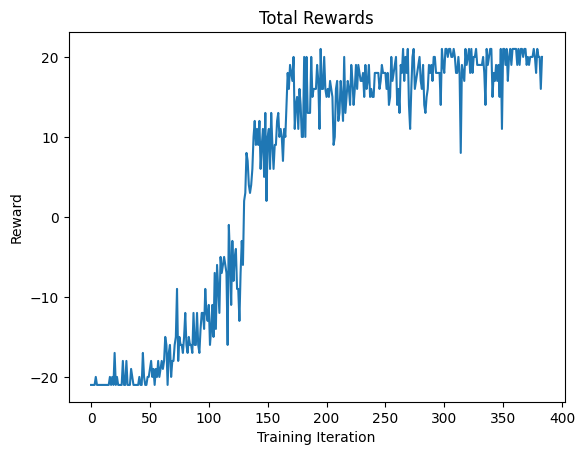

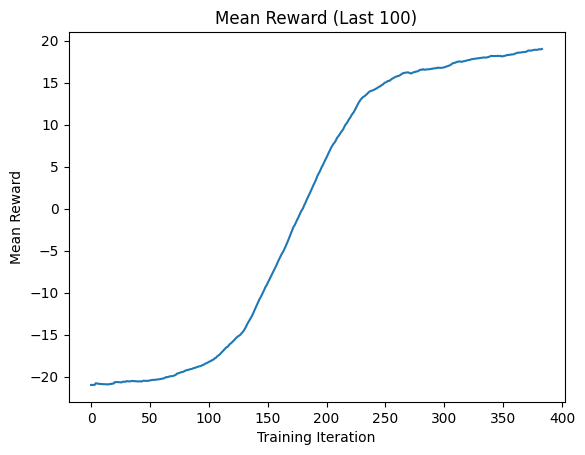

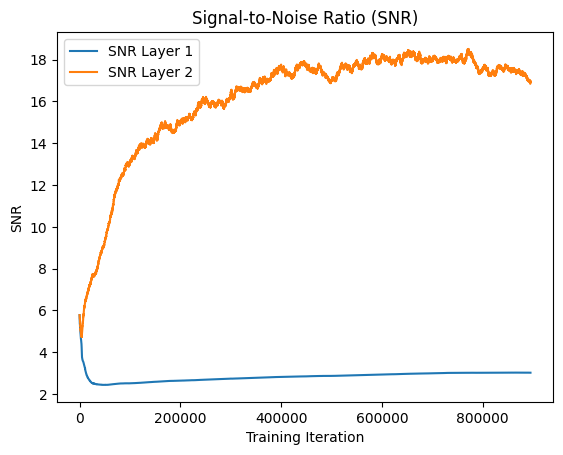

In [12]:
    # === Wykresy ===
    plt.figure()
    plt.plot(reward_iterations := [i for i, r in enumerate(rewards)], rewards)
    plt.title("Total Rewards")
    plt.xlabel("Training Iteration")
    plt.ylabel("Reward")
    plt.savefig("reward_plot.png")

    mean_rewards = [np.mean(rewards[max(0, i-99):i+1]) for i in range(len(rewards))]
    plt.figure()
    plt.plot(reward_iterations, mean_rewards)
    plt.title("Mean Reward (Last 100)")
    plt.xlabel("Training Iteration")
    plt.ylabel("Mean Reward")
    plt.savefig("reward_mean_plot.png")

    plt.figure()
    plt.plot(snr_1_list, label="SNR Layer 1")
    plt.plot(snr_2_list, label="SNR Layer 2")
    plt.title("Signal-to-Noise Ratio (SNR)")
    plt.xlabel("Training Iteration")
    plt.ylabel("SNR")
    plt.legend()
    plt.savefig("snr_plot.png")

In [17]:
# === Wykresy ===
from tensorboard.backend.event_processing import event_accumulator

log_dir = writer.log_dir if hasattr(writer, 'log_dir') else "runs"
event_files = []
for root, dirs, files in os.walk(log_dir):
    for file in files:
        if file.startswith("events.out.tfevents"):
            event_files.append(os.path.join(root, file))

if len(event_files) > 0:
    ea = event_accumulator.EventAccumulator(event_files[0])
    ea.Reload()

    for tag, title, fname in [
        ("reward_100", "Średnia nagroda (100 gier)", "reward_mean_plot.png"),
        ("reward", "Nagroda", "reward_plot.png")
    ]:
        try:
            scalars = ea.Scalars(tag)
            steps = [s.step for s in scalars]
            values = [s.value for s in scalars]
            plt.figure(figsize=(12, 5))
            plt.plot(steps, values)
            plt.xlabel("Iteracja")
            plt.ylabel(title)
            plt.title(f"Trening – {title}")
            plt.grid()
            plt.tight_layout()
            plt.savefig(fname)
            plt.close()
        except KeyError:
            print(f"⚠️ Nie znaleziono danych dla tagu: {tag}")

    # SNR warstwy 1 i 2 na jednym wykresie
    try:
        snr1 = ea.Scalars("SNR/layer1")
        snr2 = ea.Scalars("SNR/layer2")
        steps1 = [s.step for s in snr1]
        values1 = [s.value for s in snr1]
        steps2 = [s.step for s in snr2]
        values2 = [s.value for s in snr2]

        plt.figure(figsize=(12, 5))
        plt.plot(steps1, values1, label="SNR warstwa 1")
        plt.plot(steps2, values2, label="SNR warstwa 2")
        plt.xlabel("Iteracja")
        plt.ylabel("SNR")
        plt.title("Trening – SNR warstw Noisy DQN")
        plt.legend()
        plt.grid()
        plt.tight_layout()
        plt.savefig("snr_plot.png")
        plt.close()
    except KeyError:
        print("⚠️ Nie znaleziono danych SNR dla warstw noisy.")
else:
    print("⚠️ Brak plików logów TensorBoard do wygenerowania wykresów.")
